[Data source](https://github.com/KnowSciEng/tmmc/blob/master/data/usecase%231.csv)

# Using CausalNex for Use Cases in Car Procedure Project

In [1]:
import os
from typing import *


os.getcwd()
# Setting the baseline:
os.chdir('/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP')


curPath: str = os.getcwd() + "/src/CausalNexStudy/"

dataPath: str = curPath + "data/"


print("curPath = ", curPath, "\n")
print("dataPath = ", dataPath, "\n")

curPath =  /development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/CausalNexStudy/ 

dataPath =  /development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/CausalNexStudy/data/ 



In [2]:
import sys
# Making files in utils folder visible here: to import my local print functions for nn.Module objects
sys.path.append(os.getcwd() + "/src/utils/")
# For being able to import files within CausalNex folder
sys.path.append(curPath)

sys.path

['/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/CausalNexStudy',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python37.zip',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/lib-dynload',
 '',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/IPython/extensions',
 '/home/statisticallyfit/.ipython',
 '/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/utils/',
 '/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/CausalNexStudy/']

# 1/ Structure Learning
## Structure from Domain Knowledge
We can manually define a structure model by specifying the relationships between different features.
First we must create an empty structure model.

In [3]:
from causalnex.structure import StructureModel

carStructModel: StructureModel = StructureModel()

## Learning the Structure
Can use CausalNex to learn structure model from data, when number of variables grows or domain knowledge does not exist. (Algorithm used is the [NOTEARS algorithm](https://arxiv.org/abs/1803.01422)).
* NOTE: not always necessary to train / test split because structure learning should be a joint effort between machine learning and domain experts.

First must pre-process the data so the [NOTEARS algorithm](https://arxiv.org/abs/1803.01422) can be used.

## Preparing the Data for Structure Learning
* $\color{red}{\text{ALERT: }}$ very important, MUST have the column names have nonoe of these characters: ?! - ; else will get error from the `InferenceEngine.__init__` function as: `"Variable names must match ^[0-9a-zA-Z_]+$ - please fix the following nodes: {0}".format(bad_nodes)`

* $\color{red}{\text{ALERT: }}$ key point, alawys use the '_' (underscore) instead of '-' (dash) character if you want to space out the column header names. Otherwise `InferenceEngine` won't work!

In [4]:
import pandas as pd
from pandas.core.frame import DataFrame


fileName: str = dataPath + 'usecase#1.csv'
data: DataFrame = pd.read_csv(fileName, delimiter = ',')

data

,ndx,process_type,tool_type,injury_type,absenteeism_level
0,1,Engine-Mount,Power-Gun,Electrical-Burn,Absenteeism-00
1,2,Engine-Mount,Forklift,Contact-Contusion,Absenteeism-03
2,3,Engine-Wiring,Power-Gun,Electrical-Shock,Absenteeism-02
3,4,Engine-Mount,Forklift,Fall-Gtm,Absenteeism-03
4,5,Sun-Roof-Housing,Power-Gun,Electrical-Burn,Absenteeism-00
5,6,Accel-Pedal,Power-Gun,Electrical-Burn,Absenteeism-00
6,7,Oil-Fill,Oil,Chemical-Burn,Absenteeism-02


In [5]:
data.columns

Index(['ndx', 'process_type    ', 'tool_type', 'injury_type      ',
       'absenteeism_level'],
      dtype='object')

In [6]:
# Removing whitespace from the column NAMES
assert data.columns[1] == 'process_type    ' and not data.columns[1] == 'process_type'

data = data.rename(columns=lambda x: x.strip()) # inplace = False
assert data.columns[1] == 'process_type'


# Removing whitespace from the column VALUES
assert data['process_type'][1] == 'Engine-Mount    ' and not data['process_type'][1] == 'Engine-Mount'
data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
assert data['process_type'][1] == 'Engine-Mount'

Dropping the useless 'ndx' column since that is not a variable:

In [7]:
data: DataFrame = data.drop(columns = ['ndx'])
data

,process_type,tool_type,injury_type,absenteeism_level
0,Engine-Mount,Power-Gun,Electrical-Burn,Absenteeism-00
1,Engine-Mount,Forklift,Contact-Contusion,Absenteeism-03
2,Engine-Wiring,Power-Gun,Electrical-Shock,Absenteeism-02
3,Engine-Mount,Forklift,Fall-Gtm,Absenteeism-03
4,Sun-Roof-Housing,Power-Gun,Electrical-Burn,Absenteeism-00
5,Accel-Pedal,Power-Gun,Electrical-Burn,Absenteeism-00
6,Oil-Fill,Oil,Chemical-Burn,Absenteeism-02


Next we want to make our data numeric since this is what the NOTEARS algorithm expects. We can do this by label-encoding the non-numeric variables (to make them also numeric, like the current numeric variables).

In [8]:
import numpy as np

labelEncData: DataFrame = data.copy()

# This operation below excludes all column variables that are number variables (so keeping only categorical variables)
labelEncData.select_dtypes(exclude=[np.number])

,process_type,tool_type,injury_type,absenteeism_level
0,Engine-Mount,Power-Gun,Electrical-Burn,Absenteeism-00
1,Engine-Mount,Forklift,Contact-Contusion,Absenteeism-03
2,Engine-Wiring,Power-Gun,Electrical-Shock,Absenteeism-02
3,Engine-Mount,Forklift,Fall-Gtm,Absenteeism-03
4,Sun-Roof-Housing,Power-Gun,Electrical-Burn,Absenteeism-00
5,Accel-Pedal,Power-Gun,Electrical-Burn,Absenteeism-00
6,Oil-Fill,Oil,Chemical-Burn,Absenteeism-02


In [9]:
# Getting the names of the categorical variables (columns)
labelEncData.select_dtypes(exclude=[np.number]).columns

Index(['process_type', 'tool_type', 'injury_type', 'absenteeism_level'], dtype='object')

In [10]:
namesOfCategoricalVars: List[str] = list(labelEncData.select_dtypes(exclude=[np.number]).columns)

namesOfCategoricalVars

['process_type', 'tool_type', 'injury_type', 'absenteeism_level']

In [11]:
from sklearn.preprocessing import LabelEncoder

labelEncoder: LabelEncoder = LabelEncoder()

# NOTE: structData keeps also the numeric columns, doesn't exclude them! just updates the non-numeric cols.
for varName in namesOfCategoricalVars:
    labelEncData[varName] = labelEncoder.fit_transform(y = labelEncData[varName])

Comparing the converted numericalized `labelEncData` with the previous `data`:

In [12]:
labelEncData

,process_type,tool_type,injury_type,absenteeism_level
0,1,2,2,0
1,1,0,1,2
2,2,2,3,1
3,1,0,4,2
4,4,2,2,0
5,0,2,2,0
6,3,1,0,1


In [13]:
data

,process_type,tool_type,injury_type,absenteeism_level
0,Engine-Mount,Power-Gun,Electrical-Burn,Absenteeism-00
1,Engine-Mount,Forklift,Contact-Contusion,Absenteeism-03
2,Engine-Wiring,Power-Gun,Electrical-Shock,Absenteeism-02
3,Engine-Mount,Forklift,Fall-Gtm,Absenteeism-03
4,Sun-Roof-Housing,Power-Gun,Electrical-Burn,Absenteeism-00
5,Accel-Pedal,Power-Gun,Electrical-Burn,Absenteeism-00
6,Oil-Fill,Oil,Chemical-Burn,Absenteeism-02


In [14]:
# The different unique values of each column variable:
dataVals = {var: data[var].unique() for var in data.columns}
dataVals

{'process_type': array(['Engine-Mount', 'Engine-Wiring', 'Sun-Roof-Housing', 'Accel-Pedal',
        'Oil-Fill'], dtype=object),
 'tool_type': array(['Power-Gun', 'Forklift', 'Oil'], dtype=object),
 'injury_type': array(['Electrical-Burn', 'Contact-Contusion', 'Electrical-Shock',
        'Fall-Gtm', 'Chemical-Burn'], dtype=object),
 'absenteeism_level': array(['Absenteeism-00', 'Absenteeism-03', 'Absenteeism-02'], dtype=object)}

In [15]:
# All the values we convert in structData are binary, so testing how a non-binary one gets converted here:
testMultivals: List[str] = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

assert list(labelEncoder.fit_transform(y = testMultivals)) == [0, 1, 2, 3, 4, 5, 6, 7]

Now apply the NOTEARS algo to learn the structure:

In [16]:

# from src.utils.Clock import *
def clock(startTime, endTime):
    elapsedTime = endTime - startTime
    elapsedMins = int(elapsedTime / 60)
    elapsedSecs = int(elapsedTime - (elapsedMins * 60))
    return elapsedMins, elapsedSecs

In [17]:
from causalnex.structure.notears import from_pandas
import time

startTime: float = time.time()

carStructLearned = from_pandas(X = labelEncData)

print(f"Time taken = {clock(startTime = startTime, endTime = time.time())}")

Time taken = (0, 1)


/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pygraphviz/agraph.py:1367: RuntimeWarning: Warning: node 'process_type', graph '%3' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


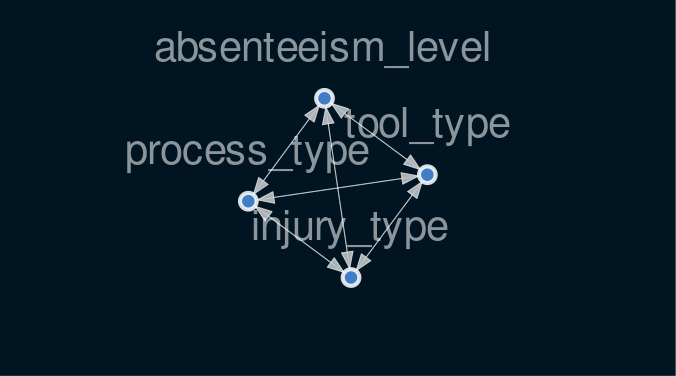

In [18]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

# Now visualize it:
viz = plot_structure(
    carStructLearned,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename_carLearned = curPath + "car_learnedStructure.png"

viz.draw(filename_carLearned)
Image(filename_carLearned)



Getting detailed view into the learned model:

In [19]:
carStructLearned.adj

AdjacencyView({'process_type': {'tool_type': {'origin': 'learned', 'weight': 1.6013884142415616e-05}, 'injury_type': {'origin': 'learned', 'weight': -4.1115279254464356e-05}, 'absenteeism_level': {'origin': 'learned', 'weight': 1.3208799237580814e-05}}, 'tool_type': {'process_type': {'origin': 'learned', 'weight': 1.2071187794204359}, 'injury_type': {'origin': 'learned', 'weight': 0.8760435347215887}, 'absenteeism_level': {'origin': 'learned', 'weight': 5.6556552801123675e-05}}, 'injury_type': {'process_type': {'origin': 'learned', 'weight': -0.364442866393215}, 'tool_type': {'origin': 'learned', 'weight': 3.104569670498457e-05}, 'absenteeism_level': {'origin': 'learned', 'weight': 1.9624416941608718e-05}}, 'absenteeism_level': {'process_type': {'origin': 'learned', 'weight': 1.010605904632349}, 'tool_type': {'origin': 'learned', 'weight': 0.2987294416064669}, 'injury_type': {'origin': 'learned', 'weight': 1.0374394487292051}}})

In [20]:
carStructLearned.degree

DiDegreeView({'process_type': 6, 'tool_type': 6, 'injury_type': 6, 'absenteeism_level': 6})

In [21]:
carStructLearned.edges

OutEdgeView([('process_type', 'tool_type'), ('process_type', 'injury_type'), ('process_type', 'absenteeism_level'), ('tool_type', 'process_type'), ('tool_type', 'injury_type'), ('tool_type', 'absenteeism_level'), ('injury_type', 'process_type'), ('injury_type', 'tool_type'), ('injury_type', 'absenteeism_level'), ('absenteeism_level', 'process_type'), ('absenteeism_level', 'tool_type'), ('absenteeism_level', 'injury_type')])

In [22]:
carStructLearned.in_degree

InDegreeView({'process_type': 3, 'tool_type': 3, 'injury_type': 3, 'absenteeism_level': 3})

In [23]:
carStructLearned.in_edges

InEdgeView([('tool_type', 'process_type'), ('injury_type', 'process_type'), ('absenteeism_level', 'process_type'), ('process_type', 'tool_type'), ('injury_type', 'tool_type'), ('absenteeism_level', 'tool_type'), ('process_type', 'injury_type'), ('tool_type', 'injury_type'), ('absenteeism_level', 'injury_type'), ('process_type', 'absenteeism_level'), ('tool_type', 'absenteeism_level'), ('injury_type', 'absenteeism_level')])

In [24]:
carStructLearned.number_of_nodes()

4

In [25]:
assert carStructLearned.node == carStructLearned.nodes

carStructLearned.node

NodeView(('process_type', 'tool_type', 'injury_type', 'absenteeism_level'))

In [26]:
carStructLearned.out_degree

OutDegreeView({'process_type': 3, 'tool_type': 3, 'injury_type': 3, 'absenteeism_level': 3})

In [27]:
carStructLearned.out_edges

OutEdgeView([('process_type', 'tool_type'), ('process_type', 'injury_type'), ('process_type', 'absenteeism_level'), ('tool_type', 'process_type'), ('tool_type', 'injury_type'), ('tool_type', 'absenteeism_level'), ('injury_type', 'process_type'), ('injury_type', 'tool_type'), ('injury_type', 'absenteeism_level'), ('absenteeism_level', 'process_type'), ('absenteeism_level', 'tool_type'), ('absenteeism_level', 'injury_type')])

In [28]:
# Adjacency object holding predecessors of each node
carStructLearned.pred

AdjacencyView({'process_type': {'tool_type': {'origin': 'learned', 'weight': 1.2071187794204359}, 'injury_type': {'origin': 'learned', 'weight': -0.364442866393215}, 'absenteeism_level': {'origin': 'learned', 'weight': 1.010605904632349}}, 'tool_type': {'process_type': {'origin': 'learned', 'weight': 1.6013884142415616e-05}, 'injury_type': {'origin': 'learned', 'weight': 3.104569670498457e-05}, 'absenteeism_level': {'origin': 'learned', 'weight': 0.2987294416064669}}, 'injury_type': {'process_type': {'origin': 'learned', 'weight': -4.1115279254464356e-05}, 'tool_type': {'origin': 'learned', 'weight': 0.8760435347215887}, 'absenteeism_level': {'origin': 'learned', 'weight': 1.0374394487292051}}, 'absenteeism_level': {'process_type': {'origin': 'learned', 'weight': 1.3208799237580814e-05}, 'tool_type': {'origin': 'learned', 'weight': 5.6556552801123675e-05}, 'injury_type': {'origin': 'learned', 'weight': 1.9624416941608718e-05}}})

In [29]:
# Adjacency object holding the successors of each node
carStructLearned.succ

AdjacencyView({'process_type': {'tool_type': {'origin': 'learned', 'weight': 1.6013884142415616e-05}, 'injury_type': {'origin': 'learned', 'weight': -4.1115279254464356e-05}, 'absenteeism_level': {'origin': 'learned', 'weight': 1.3208799237580814e-05}}, 'tool_type': {'process_type': {'origin': 'learned', 'weight': 1.2071187794204359}, 'injury_type': {'origin': 'learned', 'weight': 0.8760435347215887}, 'absenteeism_level': {'origin': 'learned', 'weight': 5.6556552801123675e-05}}, 'injury_type': {'process_type': {'origin': 'learned', 'weight': -0.364442866393215}, 'tool_type': {'origin': 'learned', 'weight': 3.104569670498457e-05}, 'absenteeism_level': {'origin': 'learned', 'weight': 1.9624416941608718e-05}}, 'absenteeism_level': {'process_type': {'origin': 'learned', 'weight': 1.010605904632349}, 'tool_type': {'origin': 'learned', 'weight': 0.2987294416064669}, 'injury_type': {'origin': 'learned', 'weight': 1.0374394487292051}}})

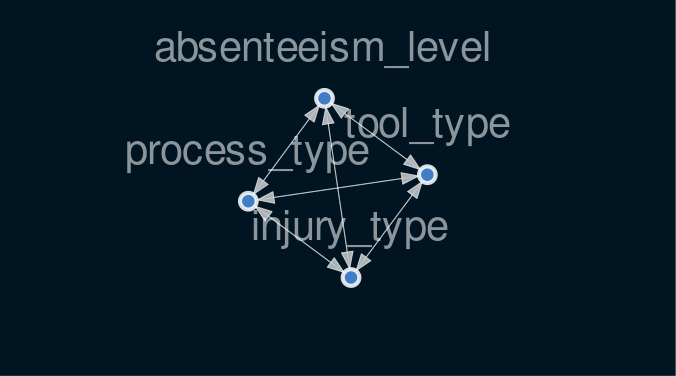

In [30]:
Image(filename_carLearned)

In [31]:
carStructLearned.has_edge(u = 'process_type', v= 'injury_type')

True

In [32]:
assert carStructLearned.adj['process_type']['injury_type'] == carStructLearned.get_edge_data(u = 'process_type', v= 'injury_type')

carStructLearned.get_edge_data(u = 'process-_type', v= 'injury_type')

In [33]:
# Checking these relations are visible in the adjacency graph:
carStructLearned.adj

AdjacencyView({'process_type': {'tool_type': {'origin': 'learned', 'weight': 1.6013884142415616e-05}, 'injury_type': {'origin': 'learned', 'weight': -4.1115279254464356e-05}, 'absenteeism_level': {'origin': 'learned', 'weight': 1.3208799237580814e-05}}, 'tool_type': {'process_type': {'origin': 'learned', 'weight': 1.2071187794204359}, 'injury_type': {'origin': 'learned', 'weight': 0.8760435347215887}, 'absenteeism_level': {'origin': 'learned', 'weight': 5.6556552801123675e-05}}, 'injury_type': {'process_type': {'origin': 'learned', 'weight': -0.364442866393215}, 'tool_type': {'origin': 'learned', 'weight': 3.104569670498457e-05}, 'absenteeism_level': {'origin': 'learned', 'weight': 1.9624416941608718e-05}}, 'absenteeism_level': {'process_type': {'origin': 'learned', 'weight': 1.010605904632349}, 'tool_type': {'origin': 'learned', 'weight': 0.2987294416064669}, 'injury_type': {'origin': 'learned', 'weight': 1.0374394487292051}}})

NOTE: sometimes the edge weights are NOT the same, going from opposite directions. For instance there is a greater edge weight from `absenteeism-level` --> `injury-type` but a very small edge weight the other way around, from `injury-type` --> `absenteeism-level`, because it is more likely for injury type to influence absenteeism
* $\color{red}{\text{TODO: check if this is verified by the data}}$

In [34]:
carStructLearned.get_edge_data(u = 'absenteeism_level', v = 'injury_type')

{'origin': 'learned', 'weight': 1.0374394487292051}

In [35]:
carStructLearned.get_edge_data(u = 'injury_type', v = 'absenteeism_level')

{'origin': 'learned', 'weight': 1.9624416941608718e-05}

In [36]:
carStructLearned.nodes

NodeView(('process_type', 'tool_type', 'injury_type', 'absenteeism_level'))

In [37]:
# Checking that currently, there is only one subgraph and it is the entire subgraph
assert carStructLearned.adj ==  carStructLearned.get_largest_subgraph().adj  == carStructLearned.get_target_subgraph(node = 'injury_type').adj == carStructLearned.get_target_subgraph(node = 'process_type').adj == carStructLearned.get_target_subgraph(node = 'tool_type').adj == carStructLearned.get_target_subgraph(node = 'absenteeism_level').adj

# TODO: what does negative weight mean?
# TODO: why are weights not probabilities?
list(carStructLearned.adjacency())



[('process_type',
  {'tool_type': {'origin': 'learned', 'weight': 1.6013884142415616e-05},
   'injury_type': {'origin': 'learned', 'weight': -4.1115279254464356e-05},
   'absenteeism_level': {'origin': 'learned',
    'weight': 1.3208799237580814e-05}}),
 ('tool_type',
  {'process_type': {'origin': 'learned', 'weight': 1.2071187794204359},
   'injury_type': {'origin': 'learned', 'weight': 0.8760435347215887},
   'absenteeism_level': {'origin': 'learned',
    'weight': 5.6556552801123675e-05}}),
 ('injury_type',
  {'process_type': {'origin': 'learned', 'weight': -0.364442866393215},
   'tool_type': {'origin': 'learned', 'weight': 3.104569670498457e-05},
   'absenteeism_level': {'origin': 'learned',
    'weight': 1.9624416941608718e-05}}),
 ('absenteeism_level',
  {'process_type': {'origin': 'learned', 'weight': 1.010605904632349},
   'tool_type': {'origin': 'learned', 'weight': 0.2987294416064669},
   'injury_type': {'origin': 'learned', 'weight': 1.0374394487292051}})]

Must prune the model in effort to make the structure acyclic (prerequisite for the bayesian network)

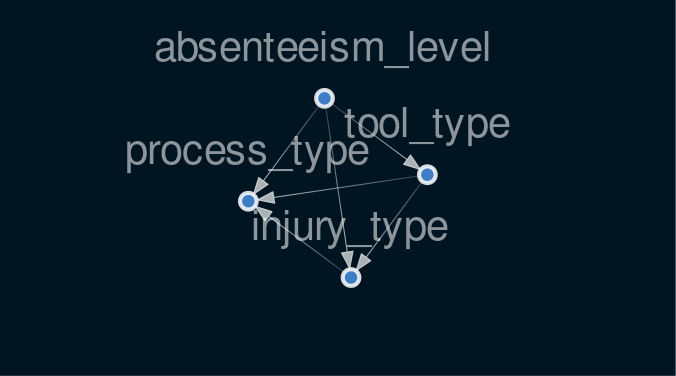

In [38]:
carStructPruned = carStructLearned.copy()
carStructPruned.remove_edges_below_threshold(threshold = 0.1)

# Now visualize:

# Now visualize it:
viz = plot_structure(
    carStructPruned,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
filename_carPruned = curPath + "car_prunedstructure.png"

viz.draw(filename_carPruned)
Image(filename_carPruned)

In [39]:
# Quick view into the result
list(carStructPruned.adjacency())

[('process_type', {}),
 ('tool_type',
  {'process_type': {'origin': 'learned', 'weight': 1.2071187794204359},
   'injury_type': {'origin': 'learned', 'weight': 0.8760435347215887}}),
 ('injury_type',
  {'process_type': {'origin': 'learned', 'weight': -0.364442866393215}}),
 ('absenteeism_level',
  {'process_type': {'origin': 'learned', 'weight': 1.010605904632349},
   'tool_type': {'origin': 'learned', 'weight': 0.2987294416064669},
   'injury_type': {'origin': 'learned', 'weight': 1.0374394487292051}})]

In [40]:
list(carStructLearned.adjacency())

[('process_type',
  {'tool_type': {'origin': 'learned', 'weight': 1.6013884142415616e-05},
   'injury_type': {'origin': 'learned', 'weight': -4.1115279254464356e-05},
   'absenteeism_level': {'origin': 'learned',
    'weight': 1.3208799237580814e-05}}),
 ('tool_type',
  {'process_type': {'origin': 'learned', 'weight': 1.2071187794204359},
   'injury_type': {'origin': 'learned', 'weight': 0.8760435347215887},
   'absenteeism_level': {'origin': 'learned',
    'weight': 5.6556552801123675e-05}}),
 ('injury_type',
  {'process_type': {'origin': 'learned', 'weight': -0.364442866393215},
   'tool_type': {'origin': 'learned', 'weight': 3.104569670498457e-05},
   'absenteeism_level': {'origin': 'learned',
    'weight': 1.9624416941608718e-05}}),
 ('absenteeism_level',
  {'process_type': {'origin': 'learned', 'weight': 1.010605904632349},
   'tool_type': {'origin': 'learned', 'weight': 0.2987294416064669},
   'injury_type': {'origin': 'learned', 'weight': 1.0374394487292051}})]

In [41]:
carStructPruned.degree

DiDegreeView({'process_type': 3, 'tool_type': 3, 'injury_type': 3, 'absenteeism_level': 3})

In [42]:
carStructPruned.edges

OutEdgeView([('tool_type', 'process_type'), ('tool_type', 'injury_type'), ('injury_type', 'process_type'), ('absenteeism_level', 'process_type'), ('absenteeism_level', 'tool_type'), ('absenteeism_level', 'injury_type')])

In [43]:
carStructPruned.in_degree

InDegreeView({'process_type': 3, 'tool_type': 1, 'injury_type': 2, 'absenteeism_level': 0})

In [44]:
carStructPruned.in_edges

InEdgeView([('tool_type', 'process_type'), ('injury_type', 'process_type'), ('absenteeism_level', 'process_type'), ('absenteeism_level', 'tool_type'), ('tool_type', 'injury_type'), ('absenteeism_level', 'injury_type')])

In [45]:
carStructPruned.number_of_nodes()

4

In [46]:
carStructPruned.out_degree

OutDegreeView({'process_type': 0, 'tool_type': 2, 'injury_type': 1, 'absenteeism_level': 3})

In [47]:
carStructPruned.out_edges

OutEdgeView([('tool_type', 'process_type'), ('tool_type', 'injury_type'), ('injury_type', 'process_type'), ('absenteeism_level', 'process_type'), ('absenteeism_level', 'tool_type'), ('absenteeism_level', 'injury_type')])

In [48]:
# Adjacency object holding predecessors of each node
carStructPruned.pred

AdjacencyView({'process_type': {'tool_type': {'origin': 'learned', 'weight': 1.2071187794204359}, 'injury_type': {'origin': 'learned', 'weight': -0.364442866393215}, 'absenteeism_level': {'origin': 'learned', 'weight': 1.010605904632349}}, 'tool_type': {'absenteeism_level': {'origin': 'learned', 'weight': 0.2987294416064669}}, 'injury_type': {'tool_type': {'origin': 'learned', 'weight': 0.8760435347215887}, 'absenteeism_level': {'origin': 'learned', 'weight': 1.0374394487292051}}, 'absenteeism_level': {}})

In [49]:
# Adjacency object holding the successors of each node
carStructPruned.succ

AdjacencyView({'process_type': {}, 'tool_type': {'process_type': {'origin': 'learned', 'weight': 1.2071187794204359}, 'injury_type': {'origin': 'learned', 'weight': 0.8760435347215887}}, 'injury_type': {'process_type': {'origin': 'learned', 'weight': -0.364442866393215}}, 'absenteeism_level': {'process_type': {'origin': 'learned', 'weight': 1.010605904632349}, 'tool_type': {'origin': 'learned', 'weight': 0.2987294416064669}, 'injury_type': {'origin': 'learned', 'weight': 1.0374394487292051}}})

In [50]:
# Checking that currently, there is only one subgraph and it is the entire subgraph, even in the pruned version:
assert carStructPruned.adj ==  carStructPruned.get_largest_subgraph().adj  == carStructPruned.get_target_subgraph(node = 'injury_type').adj == carStructPruned.get_target_subgraph(node = 'process_type').adj == carStructPruned.get_target_subgraph(node = 'tool_type').adj == carStructPruned.get_target_subgraph(node = 'absenteeism_level').adj

After deciding on how the final structure model should look, we can instantiate a `BayesianNetwork`:

In [51]:
from causalnex.network import BayesianNetwork

bayesNet: BayesianNetwork = BayesianNetwork(structure = carStructPruned)
bayesNet.cpds

{}

In [52]:
bayesNet.edges
#bayesNet.node_states # error

[('tool_type', 'process_type'),
 ('tool_type', 'injury_type'),
 ('injury_type', 'process_type'),
 ('absenteeism_level', 'process_type'),
 ('absenteeism_level', 'tool_type'),
 ('absenteeism_level', 'injury_type')]

In [53]:
assert set(bayesNet.nodes) == set(list(iter(carStructPruned.nodes)))

bayesNet.nodes

['tool_type', 'process_type', 'injury_type', 'absenteeism_level']

Can now learn the conditional probability distribution of different features in this `BayesianNetwork`

# 2/ Fitting the Conditional Distribution of the Bayesian Network
## Preparing the Discretised Data
Any continuous features should be discretised prior to fitting the Bayesian Network, since CausalNex networks support only discrete distributions.

Should make numerical features categorical by discretisation then give the buckets meaningful labels.
## 1. Reducing Cardinality of Categorical Features
To reduce cardinality of categorical features (reduce number of values they take on), can define a map `{oldValue: newValue}` and use this to update the feature we will discretise. Example: for the `studytime` feature, if the studytime is more than $2$ then categorize it as `long-studytime` and the rest of the values are binned under `short_studytime`.

* $\color{orange}{\text{NOTE: not needed here}}$

In [54]:
#discrData: DataFrame = data.copy()

# Getting unique values per variable
#dataVals = {var: data[var].unique() for var in data.columns}
#dataVals

In [55]:
#failuresMap = {v: 'no_failure' if v == [0] else 'yes_failure'
#               for v in dataVals['failures']} # 0, 1, 2, 3 (number of failures)
#studytimeMap = {v: 'short_studytime' if v in [1,2] else 'long_studytime'
#                for v in dataVals['studytime']}

# Once we have defined the maps `{oldValue: newValue}` we can update each feature, applying the map transformation. The `map` function applies the given dictionary as a rule to the called dictionary.
#discrData['failures'] = discrData['failures'].map(failuresMap)
#discrData['studytime'] = discrData['studytime'].map(studytimeMap)

## 2. Discretising Numeric Features
To make numeric features categorical, they must first by discretised. The `causalnex.discretiser.Discretiser` helper class supports several discretisation methods.
Here, the `fixed` method will be applied, providing static values that define the bucket boundaries. For instance, `absences` will be discretised into buckets `< 1`, `1 to 9`, and `>= 10`. Each bucket will be labelled as an integer, starting from zero.

* $\color{orange}{\text{NOTE: not needed here}}$

In [56]:
from causalnex.discretiser import Discretiser

# Many values in absences, G1, G2, G3

#discrData['absences'] = Discretiser(method = 'fixed', numeric_split_points = [1,10]).transform(data = data['absences'].values)
#assert (np.unique(discrData['absences']) == np.array([0,1,2])).all()


#discrData['G1'] = Discretiser(method = 'fixed', numeric_split_points = [10]).transform(data = data['G1'].values)
#assert (np.unique(discrData['G1']) == np.array([0,1])).all()


#discrData['G2'] = Discretiser(method = 'fixed', numeric_split_points = [10]).transform(data = data['G2'].values)
#assert (np.unique(discrData['G2']) == np.array([0,1])).all()

#discrData['G3'] = Discretiser(method = 'fixed', numeric_split_points = [10]).transform(data = data['G3'].values)
#assert (np.unique(discrData['G3']) == np.array([0,1])).all()

## 3. Create Labels for Numeric Features
To make the discretised categories more readable, we can map the category labels onto something more meaningful in the same way we mapped category feature values.

* $\color{orange}{\text{NOTE: not needed here}}$

In [57]:

#absencesMap = {0: "No-absence", 1:"Low-absence", 2:"High-absence"}

#G1Map = {0: "Fail", 1: "Pass"}
#G2Map = {0: "Fail", 1: "Pass"}
#G3Map = {0: "Fail", 1: "Pass"}

#discrData['absences'] = discrData['absences'].map(absencesMap)

#discrData['G1'] = discrData['G1'].map(G1Map)
#discrData['G2'] = discrData['G2'].map(G2Map)
#discrData['G3'] = discrData['G3'].map(G3Map)


# Now for reference later get the discrete data values also:
#discrDataVals = {var: discrData[var].unique() for var in discrData.columns}



## 4. Train / Test Split
Must train and test split data to help validate findings.
Split 90% train and 10% test.

* $\color{orange}{\text{NOTE: not needed here}}$

In [58]:
#from sklearn.model_selection import train_test_split

#train, test = train_test_split(discrData,
#                               train_size = 0.9, test_size = 0.10,
#                               random_state = 7)

# 3/ Model Probability
With the learnt structure model and discretised data, we can now fit the probability distribution of the Bayesian Network.

**First Step:** The first step is to specify all the states that each node can take. Can be done from data or can provide dictionary of node values. Here, we use the full dataset to avoid cases where states in our test set do not exist in the training set. In the real world, those states would need to be provided using the dictionary method.

In [59]:
import copy


# First 'copying' the object so previous state is preserved:
# SOURCE: https://www.geeksforgeeks.org/copy-python-deep-copy-shallow-copy/
bayesNetNodeStates = copy.deepcopy(bayesNet)
assert not bayesNetNodeStates == bayesNet, "Deepcopy bayesnet object must work"
# bayesNetNodeStates = BayesianNetwork(bayesNet.structure)

bayesNetNodeStates: BayesianNetwork = bayesNetNodeStates.fit_node_states(df = data)
bayesNetNodeStates.node_states

{'process_type': {'Accel-Pedal',
  'Engine-Mount',
  'Engine-Wiring',
  'Oil-Fill',
  'Sun-Roof-Housing'},
 'tool_type': {'Forklift', 'Oil', 'Power-Gun'},
 'injury_type': {'Chemical-Burn',
  'Contact-Contusion',
  'Electrical-Burn',
  'Electrical-Shock',
  'Fall-Gtm'},
 'absenteeism_level': {'Absenteeism-00', 'Absenteeism-02', 'Absenteeism-03'}}

## Fit Conditional Probability Distributions
The `fit_cpds` method of `BayesianNetwork` accepts a dataset to learn the conditional probability distributions (CPDs) of **each node** along with a method of how to do this fit.

In [60]:
# Copying the object information
bayesNetCPD: BayesianNetwork = copy.deepcopy(bayesNetNodeStates)

# Fitting the CPDs
bayesNetCPD: BayesianNetwork = bayesNetCPD.fit_cpds(data = data,
                                                    method = "BayesianEstimator",
                                                    bayes_prior = "K2")

/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pandas/core/generic.py:5191: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pandas/core/generic.py:5192: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimators/base.py:54: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  states = sorted(list(self.data.ix[:, variable].dropna().unique()))
/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/pgmpy/estimator

In [61]:
bayesNetCPD.cpds

{'tool_type': absenteeism_level Absenteeism-00 Absenteeism-02 Absenteeism-03
 tool_type                                                     
 Forklift                0.333333       0.333333       0.333333
 Oil                     0.333333       0.333333       0.333333
 Power-Gun               0.333333       0.333333       0.333333,
 'process_type': absenteeism_level Absenteeism-00                                        \
 injury_type        Chemical-Burn                Contact-Contusion        
 tool_type               Forklift  Oil Power-Gun          Forklift  Oil   
 process_type                                                             
 Accel-Pedal                  0.2  0.2       0.2               0.2  0.2   
 Engine-Mount                 0.2  0.2       0.2               0.2  0.2   
 Engine-Wiring                0.2  0.2       0.2               0.2  0.2   
 Oil-Fill                     0.2  0.2       0.2               0.2  0.2   
 Sun-Roof-Housing             0.2  0.2       0.2  

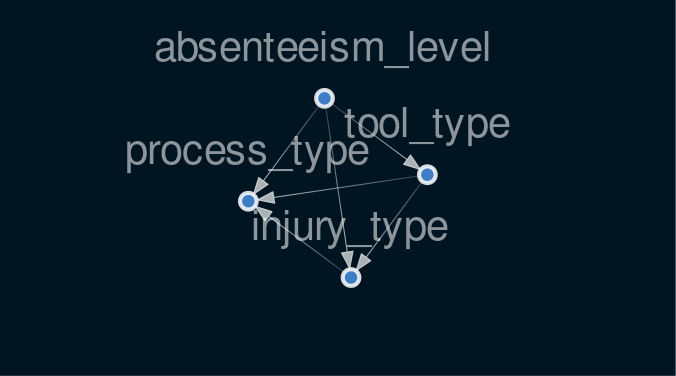

In [62]:
# The size of the tables depends on how many connections a node has
Image(filename_carPruned)

In [63]:
# G1 has many connections so its table holds all the combinations of conditional probabilities.
bayesNetCPD.cpds['absenteeism_level']

,
absenteeism_level,
Absenteeism-00,0.4
Absenteeism-02,0.3
Absenteeism-03,0.3


In [64]:
bayesNetCPD.cpds['process_type']

absenteeism_level Absenteeism-00                                        \
injury_type        Chemical-Burn                Contact-Contusion        
tool_type               Forklift  Oil Power-Gun          Forklift  Oil   
process_type                                                             
Accel-Pedal                  0.2  0.2       0.2               0.2  0.2   
Engine-Mount                 0.2  0.2       0.2               0.2  0.2   
Engine-Wiring                0.2  0.2       0.2               0.2  0.2   
Oil-Fill                     0.2  0.2       0.2               0.2  0.2   
Sun-Roof-Housing             0.2  0.2       0.2               0.2  0.2   

absenteeism_level                                                            \
injury_type                 Electrical-Burn                Electrical-Shock   
tool_type         Power-Gun        Forklift  Oil Power-Gun         Forklift   
process_type                                                                  
Accel-Pedal             0.2             0.2  0.2     0.250              0.2   
Engine-Mount            0.2             0.2  0.2     0.250              0.2   
Engine-Wiring           0.2             0.2  0.2     0.125              0.2   
Oil-Fill                0.2             0.2  0.2     0.125              0.2   
Sun-Roof-Housing        0.2             0.2  0.2     0.250              0.2   

absenteeism_level  ...    Absenteeism-03                                 \
injury_type        ... Contact-Contusion Electrical-Burn                  
tool_type          ...         Power-Gun        Forklift  Oil Power-Gun   
process_type       ...                                                    
Accel-Pedal        ...               0.2             0.2  0.2       0.2   
Engine-Mount       ...               0.2             0.2  0.2       0.2   
Engine-Wiring      ...               0.2             0.2  0.2       0.2   
Oil-Fill           ...               0.2             0.2  0.2       0.2   
Sun-Roof-Housing   ...               0.2             0.2  0.2       0.2   

absenteeism_level                                                           
injury_type       Electrical-Shock                 Fall-Gtm                 
tool_type                 Forklift  Oil Power-Gun  Forklift  Oil Power-Gun  
process_type                                                                
Accel-Pedal                    0.2  0.2       0.2  0.166667  0.2       0.2  
Engine-Mount                   0.2  0.2       0.2  0.333333  0.2       0.2  
Engine-Wiring                  0.2  0.2       0.2  0.166667  0.2       0.2  
Oil-Fill                       0.2  0.2       0.2  0.166667  0.2       0.2  
Sun-Roof-Housing               0.2  0.2       0.2  0.166667  0.2       0.2  

[5 rows x 45 columns]

In [65]:
bayesNetCPD.cpds['tool_type']

absenteeism_level,Absenteeism-00,Absenteeism-02,Absenteeism-03
tool_type,,,
Forklift,0.333333,0.333333,0.333333
Oil,0.333333,0.333333,0.333333
Power-Gun,0.333333,0.333333,0.333333


In [66]:
bayesNetCPD.cpds['injury_type']

absenteeism_level Absenteeism-00                Absenteeism-02            \
tool_type               Forklift  Oil Power-Gun       Forklift       Oil   
injury_type                                                                
Chemical-Burn                0.2  0.2     0.125            0.2  0.333333   
Contact-Contusion            0.2  0.2     0.125            0.2  0.166667   
Electrical-Burn              0.2  0.2     0.500            0.2  0.166667   
Electrical-Shock             0.2  0.2     0.125            0.2  0.166667   
Fall-Gtm                     0.2  0.2     0.125            0.2  0.166667   

absenteeism_level           Absenteeism-03                 
tool_type         Power-Gun       Forklift  Oil Power-Gun  
injury_type                                                
Chemical-Burn      0.166667       0.142857  0.2       0.2  
Contact-Contusion  0.166667       0.285714  0.2       0.2  
Electrical-Burn    0.166667       0.142857  0.2       0.2  
Electrical-Shock   0.333333       0.142857  0.2       0.2  
Fall-Gtm           0.166667       0.285714  0.2       0.2

The CPD dictionaries are multiindexed so the `loc` function can be a useful way to interact with them:

In [67]:
# TODO: https://hyp.is/_95epIOuEeq_HdeYjzCPXQ/causalnex.readthedocs.io/en/latest/03_tutorial/03_tutorial.html
data.loc[1:5,data.columns]



,process_type,tool_type,injury_type,absenteeism_level
1,Engine-Mount,Forklift,Contact-Contusion,Absenteeism-03
2,Engine-Wiring,Power-Gun,Electrical-Shock,Absenteeism-02
3,Engine-Mount,Forklift,Fall-Gtm,Absenteeism-03
4,Sun-Roof-Housing,Power-Gun,Electrical-Burn,Absenteeism-00
5,Accel-Pedal,Power-Gun,Electrical-Burn,Absenteeism-00


## Predict the State given the Input Data
The `predict` method of `BayesianNetwork` allos us to make predictions based on the data using the learnt network. For example we want to predict if a student passes of failes the exam based on the input data. Consider an incoming student data like this:

In [68]:
# Row number 2
data.loc[2, data.columns != 'absenteeism_level']

process_type       Engine-Wiring
tool_type              Power-Gun
injury_type     Electrical-Shock
Name: 2, dtype: object

Here is the data again for reference. We see the absentee level is mid-range for this injury time `Electrical-Shock` and tool-type `Power-Gun` and process-type `Engine-Mount`

In [69]:
data

,process_type,tool_type,injury_type,absenteeism_level
0,Engine-Mount,Power-Gun,Electrical-Burn,Absenteeism-00
1,Engine-Mount,Forklift,Contact-Contusion,Absenteeism-03
2,Engine-Wiring,Power-Gun,Electrical-Shock,Absenteeism-02
3,Engine-Mount,Forklift,Fall-Gtm,Absenteeism-03
4,Sun-Roof-Housing,Power-Gun,Electrical-Burn,Absenteeism-00
5,Accel-Pedal,Power-Gun,Electrical-Burn,Absenteeism-00
6,Oil-Fill,Oil,Chemical-Burn,Absenteeism-02


Based on this data, want to predict if this particular observation (worker) will have a high absence level.

There are two kinds of prediction methods:
* [`predict_probability(data, node)`](https://causalnex.readthedocs.io/en/latest/source/api_docs/causalnex.network.BayesianNetwork.html#causalnex.network.BayesianNetwork.predict_probability): Predict the **probability of each possible state of a node**, based on some input data.
* [`predict(data, node)`](https://causalnex.readthedocs.io/en/latest/source/api_docs/causalnex.network.BayesianNetwork.html#causalnex.network.BayesianNetwork.predict): Predict the **state of a node ** based on some input data, using the Bayesian Network.

In [70]:

predictionProbs = bayesNetCPD.predict_probability(data = data, node = 'absenteeism_level')
predictionProbs

,absenteeism_level_Absenteeism-02,absenteeism_level_Absenteeism-03,absenteeism_level_Absenteeism-00
0,0.3,0.3,0.4
1,0.3,0.3,0.4
2,0.3,0.3,0.4
3,0.3,0.3,0.4
4,0.3,0.3,0.4
5,0.3,0.3,0.4
6,0.3,0.3,0.4


In [71]:
# More likely to have no absentee level for those variables than to have absentee level 2
predictionProbs.loc[2, :]

absenteeism_level_Absenteeism-02    0.3
absenteeism_level_Absenteeism-03    0.3
absenteeism_level_Absenteeism-00    0.4
Name: 2, dtype: float64

In [72]:
# This function does predictions for ALL observations (all workers)
predictions = bayesNetCPD.predict(data = data, node = 'absenteeism_level')
predictions

,absenteeism_level_prediction
0,Absenteeism-00
1,Absenteeism-00
2,Absenteeism-00
3,Absenteeism-00
4,Absenteeism-00
5,Absenteeism-00
6,Absenteeism-00


Compare this prediction to the ground truth:

In [73]:
data

,process_type,tool_type,injury_type,absenteeism_level
0,Engine-Mount,Power-Gun,Electrical-Burn,Absenteeism-00
1,Engine-Mount,Forklift,Contact-Contusion,Absenteeism-03
2,Engine-Wiring,Power-Gun,Electrical-Shock,Absenteeism-02
3,Engine-Mount,Forklift,Fall-Gtm,Absenteeism-03
4,Sun-Roof-Housing,Power-Gun,Electrical-Burn,Absenteeism-00
5,Accel-Pedal,Power-Gun,Electrical-Burn,Absenteeism-00
6,Oil-Fill,Oil,Chemical-Burn,Absenteeism-02


# 4/ Model Quality
To evaluate the quality of the model that has been learned, CausalNex supports two main approaches: Classification Report and Reciever Operating Characteristics (ROC) / Area Under the ROC Curve (AUC).
## Measure 1: Classification Report
To obtain a classification report using a BN, we need to provide a test set and the node we are trying to classify. The classification report predicts the target node for all rows (observations) in the test set and evaluate how well those predictions are made, via the model.

In [74]:
from causalnex.evaluation import classification_report

classification_report(bn = bayesNetCPD, data = data, node = 'absenteeism_level')

/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,precision,recall,f1-score,support
absenteeism_level_Absenteeism-00,0.428571,1.000000,0.600000,3
absenteeism_level_Absenteeism-02,0.000000,0.000000,0.000000,2
absenteeism_level_Absenteeism-03,0.000000,0.000000,0.000000,2
micro avg,0.428571,0.428571,0.428571,7
macro avg,0.142857,0.333333,0.200000,7
weighted avg,0.183673,0.428571,0.257143,7


**Interpret Results of classification report:** Precisions are very low for the no absentee level, and both precions and recall are very low for other absentee levels, implying we are likely to miss some of the predictions we should have made. Perhaps these missing predictions are a result of something missing in our structure
* $\color{red}{\text{ALERT:}}$  explore graph structure when the recall is bad


## Measure 2: ROC / AUC
The ROC and AUC can be obtained with `roc_auc` method within CausalNex metrics module.
ROC curve is computed by micro-averaging predictions made across all states (classes) of the target node.

In [75]:
from causalnex.evaluation import roc_auc

roc, auc = roc_auc(bn = bayesNetCPD, data = data, node = 'absenteeism_level')

print(f"ROC = \n{roc}\n")
print(f"AUC = {auc}")

ROC = 
[(0.0, 0.0), (0.2857142857142857, 0.42857142857142855), (1.0, 1.0)]

AUC = 0.5714285714285714


High value of AUC gives confidence in model performance, low value of AUC implies poor model performance.



# 5/ Querying Marginals
After iterating over our model structure, CPDs, and validating our model quality, we can **query our model under different observations** to gain insights.

## Baseline Marginals
To query the model for baseline marginals that reflect the population as a whole, a `query` method can be used.

**First:** update the model using the complete dataset since the one we currently have is built only from training data.

In [76]:
# Copy object:
bayesNetFull = copy.deepcopy(bayesNetCPD)

# Fitting CPDs with full data
bayesNetFull: BayesianNetwork = bayesNetFull.fit_cpds(data = data,
                                                     method = "BayesianEstimator",
                                                     bayes_prior = "K2")

Get warnings, showing we are replacing the previously existing CPDs

**Second**: For inference, must create a new `InferenceEngine` from our `BayesianNetwork`, which lets us query the model. The query method will compute the marginal likelihood of all states for all nodes. Query lets us get the marginal distributions, marginalizing to get rid of the conditioning variable(s) for each node variable.

In [77]:
from causalnex.inference import InferenceEngine

eng = InferenceEngine(bn = bayesNetFull)
eng

Query the baseline marginal distributions, which means querying marginals **as learned from data**:

In [78]:
marginalDistLearned: Dict[str, Dict[str, float]] = eng.query()
marginalDistLearned

{'tool_type': {'Forklift': 0.33333333333333315,
  'Oil': 0.33333333333333326,
  'Power-Gun': 0.33333333333333326},
 'process_type': {'Accel-Pedal': 0.19920634920634925,
  'Engine-Mount': 0.20873015873015874,
  'Engine-Wiring': 0.19642857142857145,
  'Oil-Fill': 0.19642857142857148,
  'Sun-Roof-Housing': 0.19920634920634925},
 'injury_type': {'Chemical-Burn': 0.19428571428571434,
  'Contact-Contusion': 0.19190476190476194,
  'Electrical-Burn': 0.22761904761904764,
  'Electrical-Shock': 0.19428571428571434,
  'Fall-Gtm': 0.19190476190476194},
 'absenteeism_level': {'Absenteeism-00': 0.4000000000000006,
  'Absenteeism-02': 0.3000000000000001,
  'Absenteeism-03': 0.30000000000000016}}

In [79]:
marginalDistLearned['injury_type']

{'Chemical-Burn': 0.19428571428571434,
 'Contact-Contusion': 0.19190476190476194,
 'Electrical-Burn': 0.22761904761904764,
 'Electrical-Shock': 0.19428571428571434,
 'Fall-Gtm': 0.19190476190476194}

In [80]:
marginalDistLearned['absenteeism_level']

{'Absenteeism-00': 0.4000000000000006,
 'Absenteeism-02': 0.3000000000000001,
 'Absenteeism-03': 0.30000000000000016}

As a quick sanity check can compute the corresponding proportion of our data , which should give nearly the same result:

In [81]:
import numpy as np

labels, counts = np.unique(data['absenteeism_level'], return_counts = True)

print(list(zip(labels, counts)))

print('\nProportions for each label: \n') # The no-absentee level has highest probability, similar to the learned bayesian result.
list(zip(labels, counts / sum(counts)))



[('Absenteeism-00', 3), ('Absenteeism-02', 2), ('Absenteeism-03', 2)]

Proportions for each label: 



[('Absenteeism-00', 0.42857142857142855),
 ('Absenteeism-02', 0.2857142857142857),
 ('Absenteeism-03', 0.2857142857142857)]

## Marginals After Observations
Can query the marginal likelihood of states in our network, **given observations**.

$\color{red}{\text{TODO}}$ is this using the Bayesian update rule?

These observations can be made anywhere in the network and their impact will be propagated through to the node of interest.

In [82]:
# Reminding of the data types for each variable:
dataVals

{'process_type': array(['Engine-Mount', 'Engine-Wiring', 'Sun-Roof-Housing', 'Accel-Pedal',
        'Oil-Fill'], dtype=object),
 'tool_type': array(['Power-Gun', 'Forklift', 'Oil'], dtype=object),
 'injury_type': array(['Electrical-Burn', 'Contact-Contusion', 'Electrical-Shock',
        'Fall-Gtm', 'Chemical-Burn'], dtype=object),
 'absenteeism_level': array(['Absenteeism-00', 'Absenteeism-03', 'Absenteeism-02'], dtype=object)}

In [83]:
# Reminder of nodes you CAN query (for instance putting a node name that doesn't exist would give an error)
bayesNetFull.nodes

['tool_type', 'process_type', 'injury_type', 'absenteeism_level']

In [84]:
# Trying to influence the injurytype variable and also later see how absentee is affected:
#marginalDistObs_biasContusion: Dict[str, Dict[str, float]] = eng.query({'injury_type': 'Contact-Contusion' })

# Seeing if biasing in favor of failing will influence the observed marginals:
#marginalDistObs_biasShock: Dict[str, Dict[str, float]] = eng.query({'injury_type': 'Electrical-Shock'})

In [85]:
# Higher probability of passing when have the above observations, since they are another set of observations in favor of passing.
marginalDistLearned['injury_type']

{'Chemical-Burn': 0.19428571428571434,
 'Contact-Contusion': 0.19190476190476194,
 'Electrical-Burn': 0.22761904761904764,
 'Electrical-Shock': 0.19428571428571434,
 'Fall-Gtm': 0.19190476190476194}

In [86]:
# Biasing towards contusion type injury
eng.query({'injury_type': 'Contact-Contusion' })['injury_type']

{'Chemical-Burn': 0.0,
 'Contact-Contusion': 1.0,
 'Electrical-Burn': 0.0,
 'Electrical-Shock': 0.0,
 'Fall-Gtm': 0.0}

In [87]:
eng.query({'injury_type': 'Contact-Contusion',
           'tool_type': 'Forklift',
           'process_type' : 'Sun-Roof-Housing' })['injury_type']

{'Chemical-Burn': 0.0,
 'Contact-Contusion': 1.0,
 'Electrical-Burn': 0.0,
 'Electrical-Shock': 0.0,
 'Fall-Gtm': 0.0}

In [88]:
# Biasing towards burn type injury
# NOTE: so far, querying the biased variable results in too obvious an answer. Below we start querying the response variable, other than the one we bias on.
eng.query({'injury_type': 'Electrical-Burn' })['injury_type']

{'Chemical-Burn': 0.0,
 'Contact-Contusion': 0.0,
 'Electrical-Burn': 1.0,
 'Electrical-Shock': 0.0,
 'Fall-Gtm': 0.0}

Interesting test cases: querying the response `absenteeism_level` after biasing, say, the `injury_type` and other variables.

* **Biasing variable:** `injury_type`
* **Querying variable:** `absenteeism_level`

In [89]:
bias: Dict[str, str] = {'injury_type' : 'Contact-Contusion'}
query: str = 'absenteeism_level'

marginalDistLearned[query]

{'Absenteeism-00': 0.4000000000000006,
 'Absenteeism-02': 0.3000000000000001,
 'Absenteeism-03': 0.30000000000000016}

In [90]:
# See absentee == 0 probability is lower than the learned version, given Contact Contusion injury, which is a serious injury
higherProbAbsent: Dict[str, float] = eng.query(bias)[query]
higherProbAbsent

{'Absenteeism-00': 0.36476426799007444,
 'Absenteeism-02': 0.2779156327543425,
 'Absenteeism-03': 0.3573200992555831}

In [91]:
# Testing less serious injury
bias['injury_type'] = 'Electrical-Burn'

# Got higher probability of no absenteeism for less serious burn!
lessProbAbsent: Dict[str, float] = eng.query(bias)[query]
lessProbAbsent

{'Absenteeism-00': 0.5271966527196652,
 'Absenteeism-02': 0.2343096234309624,
 'Absenteeism-03': 0.2384937238493724}

In [92]:
assert lessProbAbsent['Absenteeism-00'] > higherProbAbsent['Absenteeism-00'], "Should have higher probability of Absenteeism-00 for Electrical-Burn than for Contusion (burn is less serious than contusion)"

assert lessProbAbsent['Absenteeism-03'] < higherProbAbsent['Absenteeism-03'], "Should have higher probability of Absenteeism-03 for Contusion than for Electrical-Burn (Contusion is more serious than burn)"